<a href="https://colab.research.google.com/github/IshtiSikder/Optimal-allocation-of-rescue-teams-for-hostage-situations/blob/test/toy_prob.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# CTMC MDP model for rescue operational system!!!

prob <- function(opSet = policySet, t, lam, eps, mu) {
  opTRM = matrix(0, nrow = t+1, ncol = t+1)
  for (i in 2:t) {
    opTRM[i, i-1] = sum(i*eps, opSet[i]*mu)
    opTRM[i, i+1] = lam
  }
  opTRM[1, 2] = lam
  opTRM[t+1, t] = sum(t*eps, opSet[t+1]*mu)

  k = t+1
  steady_prob <- matrix(0, nrow=1, ncol=k)
  state <- matrix(0, nrow=1, ncol=k-1)
  for (i in 1:(k-1)) {
    if (i-2 < 0) {
      state[i] <- (lam/opTRM[i+1,i])
    } else {
      state[i] <- state[i-1]*(lam/opTRM[i+1,i])
    }
  }

  steady_prob[1] <- (1+sum(state))^-1
  for (i in 2:k) {
    steady_prob[i] <- state[i-1]*steady_prob[1]
  }
  return(steady_prob)
}




# Check function to determine new policy is same with current or not
checkPolicy = function(policySet, policySetnew) {
  n = 0
  for (i in policySet == policySetnew) {
    if (i == 'FALSE') {
      n = 1
    }
  }
  if (n == 0) {
    return("TRUE")
  } else {
    return("FALSE")
  }
}


# Define MDP function (for basic policy)
MDP = function(lam, mu, eps, numRescue, numTerror, costT, RC, mult) {
  r = numRescue
  t = numTerror

  #calculating costR

  costR = mult*costT*(mu+eps)


  #########################################################
  #EDITS: 22ND FEB,2023
  #NEW SERVICE RATES STRUCTURE, ADD ORIGINAL ONE AS WELL
  aijMatrix = array(0, dim = c(t+1,t+1,r+1))
  for (k in 1:(r+1)) {
    for (i in 1:t) {
      aijMatrix[i,i+1,k] <- lam
      if (i > 1) {
        #if (k==4){
          #if(i==4){
            #cat('min(k-1,i-1)',min(k-1,i-1))}}
        aijMatrix[i,i-1,k] <- sum(min(k-1,i-1)*mu+(i-1)*eps)
      }
    }
    aijMatrix[t+1,t,k] <- (min(k-1,t)*mu+t*eps)
    aijMatrix[1,2,k] <- lam
}

  for (k in 1:(r+1)) {
    for (i in 1:(t+1)) {

      aijMatrix[i,i,k] <- -sum(aijMatrix[i,,k])
    }
  }
  #########################################################


  # Design the MDP algorithm
  # Value determination
  policy = array(0, dim = c(1,t+1))
  policyOld = array(0, dim = c(1,t+1))
  policyNew = array(1, dim=c(1,t+1)) # initially set all decision is 1 in first policy
  policyTrack = array(2, dim=c(1,t+1))
  iteration = 0
  gainMatrix = c()

  while (checkPolicy(policyOld, policyNew) == 'FALSE') {
    policyOld = policyNew
    policy = policyNew
    # Design the transition matrix regarding policy
    A = array(0, dim = c(t+1,t+1))
    for (i in 1:length(policy)) {
      A[i,] = aijMatrix[i,,(policy[i])]
    }

    # Design the cost matrix regarding policy

    q = array(0,dim=c(t+1,1))
    for (i in 1:length(policy)) {

      if (RC == 'L'){
      cost = (policy[i]-1)*costR + (i-1)*eps*costT
      }

      if (RC == 'SR'){
      cost = sqrt(policy[i]-1)*costR + (i-1)*eps*costT
      }

      if (RC == 'Q'){
      cost = ((policy[i]-1)^2)*costR + (i-1)*eps*costT
      }

      q[i,1] = cost
    }


    newA = cbind(array(1, dim=c(t+1,1)), -A[,1:t])
    solution = solve(newA) %*% q
    gain = solution[1] # First row of solution is gain value
    gainMatrix = append(gainMatrix, gain)

    # Policy improvement
    newsolution = array(0, dim=c(t+1,1))
    for (i in 1:t) {
      newsolution[i] = solution[i+1]
    }


    newsolution[t+1] = 0 # Set last v value as 0 to calcultate the test quantity in policy improvement
    improveMatrix = array(0, dim=c(t+1,r+1))
    cost = array(0,dim=c(t+1,r+1))

    for (i in 1:(t+1)) {
      for (j in 1:(r+1)) {
        # Cost when we have j rescue operation and i terrorists

        if (RC == 'L'){
      cost[i,j] = (j-1)*costR + (i-1)*eps*costT
      }

      if (RC == 'SR'){
      cost[i,j] = sqrt(j-1)*costR + (i-1)*eps*costT
      }

      if (RC == 'Q'){
      cost[i,j] = ((j-1)^2)*costR + (i-1)*eps*costT
      }

        improveMatrix[i,j] = cost[i,j] + aijMatrix[i,,j] %*% newsolution

      }
    }

    # pick the minimum value among the decision
    policyNew = array(1, dim = c(1,t+1))
    for (i in 1:length(policyNew)) {
      policyNew[i] = which.min(improveMatrix[i,])
    }
    iteration = iteration + 1
    policyTrack = rbind(policyTrack, policyNew)
    policyNew
  }
  for (i in 1:length(policyNew)) {
    policyNew[i] = policyNew[i] - 1
  }
  for (i in 1:nrow(policyTrack)) {
    for (j in 1:ncol(policyTrack)) {
      policyTrack[i,j] = policyTrack[i,j] - 1
    }

  steady = prob(opSet = policyNew, t=numTerror, lam = lam, eps = eps, mu = mu)

  gain = solution[1]

  }


   #return(list(policyNew,improveMatrix,cost,aijMatrix,newsolution))

   return (policyNew)

 }

In [ ]:
ans = MDP(lam=0.2763, mu=0.2829, eps=0.1718, numRescue=10, numTerror=10, costT=1, RC='L', mult=0.5316190142082907188481)

In [ ]:
ans = ans + 1

In [ ]:
ans

1,2,3,4,5,6,7,8,9,10,1


In [ ]:
t = 10
r = 10
lam=0.2763
mu=0.2829
eps=0.1718

aijMatrix = array(0, dim = c(t+1,t+1,r+1))
  for (k in 1:(r+1)) {
    for (i in 1:t) {
      aijMatrix[i,i+1,k] <- lam
      if (i > 1) {
        #if (k==4){
          #if(i==4){
            #cat('min(k-1,i-1)',min(k-1,i-1))}}
        aijMatrix[i,i-1,k] <- sum(min(k-1,i-1)*mu+(i-1)*eps)
      }
    }
    aijMatrix[t+1,t,k] <- (min(k-1,t)*mu+t*eps)
    aijMatrix[1,2,k] <- lam
}

  for (k in 1:(r+1)) {
    for (i in 1:(t+1)) {

      aijMatrix[i,i,k] <- -sum(aijMatrix[i,,k])
    }
  }

In [ ]:
mult_test = function(cost_terror,rc,low_lim,up_lim,incr) {

prev_result = array(100,dim=c(1,11))

list_mult = list()
list_sum = list()
list_gain = list()

t = 10
r = 10
lam=0.2763
mu=0.2829
eps=0.1718

aijMatrix = array(0, dim = c(t+1,t+1,r+1))
  for (k in 1:(r+1)) {
    for (i in 1:t) {
      aijMatrix[i,i+1,k] <- lam
      if (i > 1) {
        #if (k==4){
          #if(i==4){
            #cat('min(k-1,i-1)',min(k-1,i-1))}}
        aijMatrix[i,i-1,k] <- sum(min(k-1,i-1)*mu+(i-1)*eps)
      }
    }
    aijMatrix[t+1,t,k] <- (min(k-1,t)*mu+t*eps)
    aijMatrix[1,2,k] <- lam
}

  for (k in 1:(r+1)) {
    for (i in 1:(t+1)) {

      aijMatrix[i,i,k] <- -sum(aijMatrix[i,,k])
    }
  }

for (val in seq(low_lim,up_lim, by = incr)){

        current_result = MDP(lam = 0.2763, mu = 0.2829, eps = 0.1718, numRescue=10, numTerror=10, costT=cost_terror, RC=rc, mult=val)


        if (!(identical(current_result,prev_result))) {

          steady_prob = prob(current_result,10,lam = 0.2763, mu = 0.2829, eps = 0.1718)

          sum = 0

          for (i in 1:length(current_result)){
            sum = sum + current_result[i]*steady_prob[i]
          }

          sum = sum*0.2829

          list_mult = append(list_mult,val)
          list_sum = append(list_sum,sum)

          current = current_result + 1

          A = array(0, dim = c(11,11))
          for (i in 1:length(current)) {
          A[i,] = aijMatrix[i,,(current[i])]
          }

          # Design the cost matrix regarding policy

          q = array(0,dim=c(11,1))

          costT = cost_terror

          costR = val*costT*(mu+eps)

          for (i in 1:length(current)) {

          if (rc == 'L'){
          cost = (current[i]-1)*costR + (i-1)*eps*costT
          }

          if (rc == 'SR'){
          cost = sqrt(current[i]-1)*costR + (i-1)*eps*costT
          }

          if (rc == 'Q'){
          cost = ((current[i]-1)^2)*costR + (i-1)*eps*costT
          }

          q[i,1] = cost
          }


          newA = cbind(array(1, dim=c(t+1,1)), -A[,1:t])
          solution = solve(newA) %*% q
          gain = solution[1]

          list_gain = append(list_gain,gain)

          cat('\n\n','mult:')
          print(val)
          cat('\n','Rate of success/failure:')
          print(sum)
          cat('\n','gain:')
          print(gain)
          cat('\nRC:',rc,',','\n\n')
          cat('optimal policy:\n\n')
          print(current_result)
          cat('\nsteady_prob:\n')
          print(steady_prob)



          prev_result = current_result

        }

    }

return (list(list_mult,list_sum,list_gain))

}

In [ ]:
#lowest possible increment possible in R is 0.00000000001, or 10^-11



lst = mult_test(1,'L',0,3,0.01)




 mult:[1] 0

 Rate of success/failure:[1] 0.1327892

 gain:[1] 0.1043949

RC: L , 

optimal policy:

     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11]
[1,]    0    1    2    3    4    5    6    7    8     9    10

steady_prob:
          [,1]      [,2]       [,3]       [,4]        [,5]         [,6]
[1,] 0.6340494 0.2796295 0.07145914 0.01285511 0.001784319 0.0002016143
             [,7]         [,8]         [,9]        [,10]        [,11]
[1,] 1.920898e-05 1.582091e-06 1.147508e-07 7.435484e-09 4.518197e-10


 mult:[1] 0.54

 Rate of success/failure:[1] 0.1327892

 gain:[1] 0.2535969

RC: L , 

optimal policy:

     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11]
[1,]    0    1    2    3    4    5    6    7    8     9     0

steady_prob:
          [,1]      [,2]       [,3]       [,4]        [,5]         [,6]
[1,] 0.6340494 0.2796295 0.07145914 0.01285511 0.001784319 0.0002016143
             [,7]         [,8]         [,9]        [,10]        [,11]
[1,] 1.920898e-05

In [ ]:
lst

[[1]]
[[1]][[1]]
[1] 0

[[1]][[2]]
[1] 0.54

[[1]][[3]]
[1] 0.61

[[1]][[4]]
[1] 0.62

[[1]][[5]]
[1] 0.63


[[2]]
[[2]][[1]]
[1] 0.1327892

[[2]][[2]]
[1] 0.1327892

[[2]][[3]]
[1] 0.1327892

[[2]][[4]]
[1] 0.1327889

[[2]][[5]]
[1] 0


[[3]]
[[3]][[1]]
[1] 0.1043949

[[3]][[2]]
[1] 0.2535969

[[3]][[3]]
[1] 0.2729379

[[3]][[4]]
[1] 0.2757009

[[3]][[5]]
[1] 0.2762982

In [ ]:
mult_val = unlist(lst[[1]])
rate_of_success_or_failure = unlist(lst[[2]])
gain = unlist(lst[[3]])

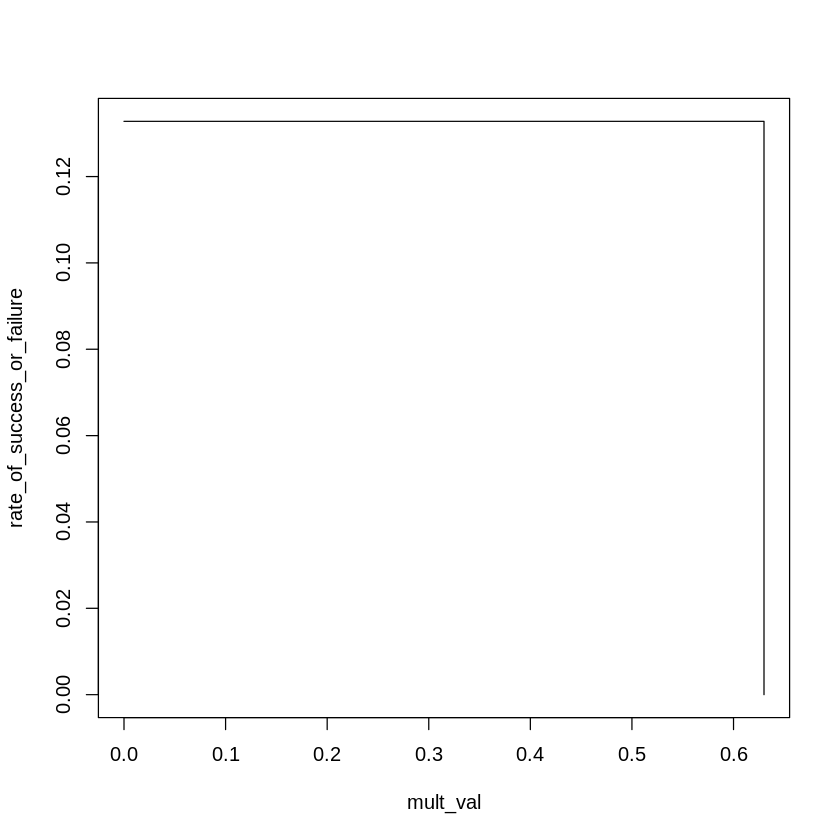

In [ ]:
plot(mult_val,rate_of_success_or_failure,'s')

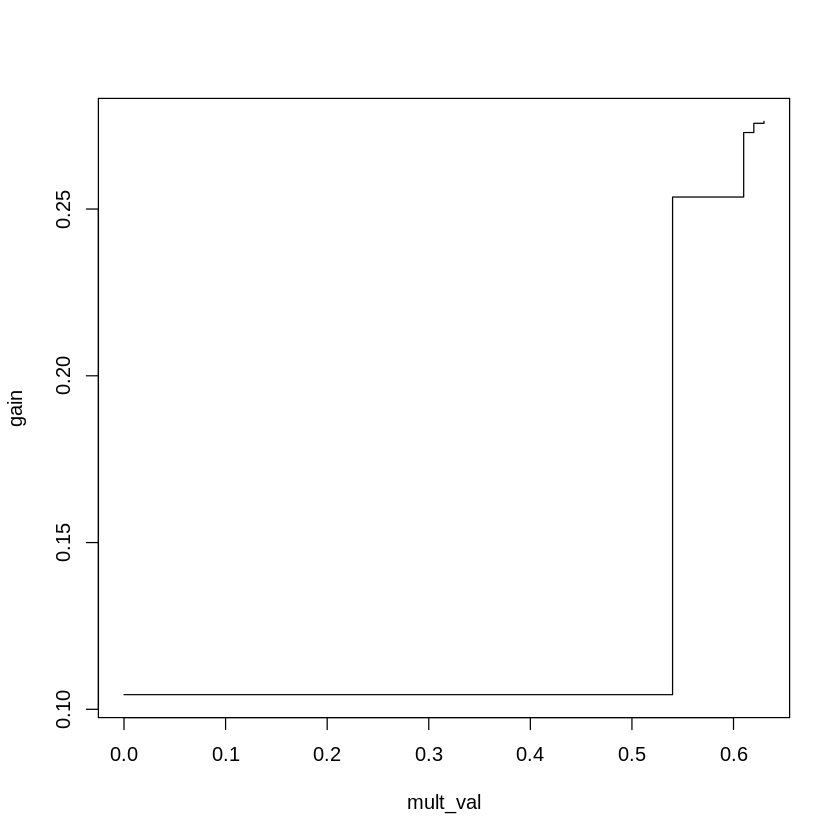

In [ ]:
plot(mult_val,gain,'s')

In [ ]:
 #THE FOLLOWING CAN BE AN ALTERNATIVE TO THE mult_test
 #tried R's apply function to avoid the delay in for loops. This doesn't work properly.
 #For some reason, runif is not creating the assigned number of random values, but less.


 mult_vals = runif(10000000,0,0.5320000000000000284217)

  mult_vals = sort(mult_matrix, decreasing=FALSE)

  mult_matrix = matrix(mult_vals,nrow=length(mult_vals))

  MDP_mult <- function(val){
  MDP(lam=0.2763, mu=0.2829, eps=0.1718, numRescue=10, numTerror=10, costT=1, RC='L', mult=val)
}

policy_matrix <- apply(mult_matrix, 1, MDP_mult)

print(unique(policy_matrix,MARGIN = 2))

ERROR: ignored

In [ ]:
#prob_search algo
#the if-else statements don't seem to be working logically for the actual prob.NEED TO FIX!
#check documentation for setequal(). You are probably applying it incorrectly.

#update1 (27TH JUNE): Rather than setequal, use double equals between arrays to compare, and then use all() function to check if all same index elements are equal between both arrays.

#update2 (27TH JUNE) : For the actual prob, guess one possible intermediary policy between two found, and run the following to get close enough upper and lower bounds.
#Then using those bounds, use the mult_test alternative to check for a large number of values in between bounds. Might work, tho clunky af.

#update3(28th JUNE) :

#1. FOR MDP(lam=0.2763, mu=0.2829, eps=0.1718, numRescue=10, numTerror=10, costT=1, RC='L', mult=val), val = 0.5312087939634377864451 yields (0,1,2,.......,9)
#2. Need to figure out how does R handle large numbers, as in how many digits does it consider after the decimal point when doing any operation
#3. If possible, convert the following to apply method, cause for loops are still clunky when the lower and upper bounds get closer together.
#4. For 2, check this link: https://floating-point-gui.de/basic/

#update3(2nd July):

#1. R is precise roughly till 16 digits after the decimal point. Rest is noise.
#2. Check algo captured on iphone camera, try it out.
#3. Is there any way to figure out unique column indices from a R column, not just the columns themselves (using unique() with MARGIN=2 applied on the matrix)?

low = 0.5312087939634377864451
up = 0.5312087939634614341955

#go = 0

prev = 'a'

for (n in 1:3){

val = runif(1,low,up)


result = MDP(lam=0.2763, mu=0.2829, eps=0.1718, numRescue=10, numTerror=10, costT=1, RC='L', mult=val)

array_1 = array(c(0,1,2,3,4,5,6,7,8,9,10))
array_2 = array(c(0,1,2,3,4,5,6,7,8,9,0))



if (all(result == matrix(array_1,nrow=1,ncol=length(array_1)))){
  low = val
  if (!prev == 'a'){
    up = prev
  }
  next
}

else if (all(result == matrix(array_2,nrow=1,ncol=length(array_2)))){
  if (!prev == 'a'){
    low = prev
  }
  up = val
  next
}

else {
  cat('inter_MULT: ')
  print(val,digits=16)
  cat('\ninter_RESULT: ',result)
  cat('\n\n')
  #go = 1
 next

}



# #if (setequal(result == array(c(0,1,2,3,4,5,6,7,8,9,9)))){
# #  cat('JACKPOT:\n\n')
# #  print(val,digits=22)
# #  cat('result: ',result)
# #  cat('\n\n')
#   go = 1
#   break
# }

# # else {
# #   if (setequal(result,array(c(0,1,2,3,4,5,6,7,8,9,10)))) {
# #   low = val
# #   if (!prev == 'a'){
# #     up = prev
# #   }
# #   next
# # }

# else if (setequal(result,array(c(0,1,2,3,4,5,6,7,8,9,0)))){
#   if (!prev == 'a'){
#     low = prev
#   }
#   up = val
#   next
# }

# else {
#   next
# }

#}

prev = val


}

#if (go == 0) {
cat('low: ')
print(low,digits=16)
cat('\n\n')

cat('val: ')
print(val,digits=16)
cat('\n\n')

cat('up: ')
print(up,digits=)
cat('\n\n')

cat('result',result)
#}

low: [1] 0.5312087939634378


val: [1] 0.5312087939634412


up: [1] 0.5312087939634412


result 0 1 2 3 4 5 6 7 8 9 0

In [ ]:
MDP_mult <- function(val){
  MDP(lam=0.2763, mu=0.2829, eps=0.1718, numRescue=10, numTerror=10, costT=1, RC='L', mult=val)
}

In [ ]:
low = 0
up = 3

vals = unique(sort(runif(10,low,up),decreasing = FALSE))
mat = matrix(vals,nrow=length(vals))
policy <- apply(mat, 1, MDP_mult)
print(mat)
print(policy)

           [,1]
 [1,] 0.1621361
 [2,] 0.2515002
 [3,] 0.3191108
 [4,] 0.4929663
 [5,] 1.0602726
 [6,] 1.4755349
 [7,] 1.4815476
 [8,] 2.3246357
 [9,] 2.6622851
[10,] 2.9315732
      [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10]
 [1,]    0    0    0    0    0    0    0    0    0     0
 [2,]    1    1    1    1    0    0    0    0    0     0
 [3,]    2    2    2    2    0    0    0    0    0     0
 [4,]    3    3    3    3    0    0    0    0    0     0
 [5,]    4    4    4    4    0    0    0    0    0     0
 [6,]    5    5    5    5    0    0    0    0    0     0
 [7,]    6    6    6    6    0    0    0    0    0     0
 [8,]    7    7    7    7    0    0    0    0    0     0
 [9,]    8    8    8    8    0    0    0    0    0     0
[10,]    9    9    9    9    0    0    0    0    0     0
[11,]   10   10   10   10    0    0    0    0    0     0


In [ ]:
sth = unique(policy,MARGIN=2)

In [ ]:
sth

0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0
10,0


In [ ]:
new = policy == sth[,1]

In [ ]:
num_uniqCols = dim(sth)[2]



In [ ]:
which(policy==sth)

[1]   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
 [19]  19  20  21  22  23  33  34  35  36  37  38  39  40  41  42  43  44  45
 [37]  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
 [55]  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
 [73]  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 [91] 100 101 102 103 104 105 106 107 108 109 110

Due to the computational limitations in R, to run large and complicated while/for loops are next to impossible. As such, to find the mult value that yields our desired policy for this toy problem (0,1,1) under any cost structure, we can follow these steps:

1. First run the mult_test function to get tentative mult values for (0,1,2) and (0,1,0) while (0,1,1) doesn't yield.

2. Next, run prob_search algo with mult_(0,1,2) as low and mult_(0,1,0) as up value. While choosing the number of iterations under the for loop running for this algo, start from an arbitrary value (i.e 100) and lower the value by i.e 10 if code doesn't finish running in i.e 1 second. Keep doing this till your iteration value has been lowered to 1. The final low and up values generated should be quite closer to each other now.

3. From this point, I am kind of blank.

Actual problem has more than one intermediary policy. How to track them all without an exhaustive search, and with prob search ? I can track assuming there are as many intermediaries as I think there should be, but what happens when I am wrong ?